In [1]:
import torch
from torch import nn
import torchvision
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import shutil

#!unzip 'drive/MyDrive/images.zip'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"GPU is available. Device: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")

# Define the directory path
train_dataset_dir = 'images/train'
test_dataset_dir = 'images/validation'

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Create the dataset
train_dataset = datasets.ImageFolder(root=train_dataset_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=test_dataset_dir, transform=transform)
print(val_dataset.targets)
# Split the dataset into training and validation sets
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print class names to verify
class_names = train_dataset.classes
print(class_names)

# Function to show an image
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis(False)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

# Select 9 random images from the batch
indices = random.sample(range(len(images)), k=9)
sampled_images = [images[i] for i in indices]
sampled_labels = [labels[i] for i in indices]

# Show images
imshow(torchvision.utils.make_grid(sampled_images), title=[class_names[sampled_labels[j]] for j in range(9)])

GPU is not available


FileNotFoundError: [Errno 2] No such file or directory: 'images/train'

In [4]:
# make the model
class MoodRecognitionModel(nn.Module):
    def __init__(self, input_shape, hidden_units, dropout_rate):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, # 1x48x48
                      out_channels=hidden_units,
                      kernel_size=3, # equivalent to tuple (3,3)
                      stride=1,
                      padding=1),
            nn.Dropout(dropout_rate),  # Adding dropout after max pooling
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # now becomes 24x24
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.Dropout(dropout_rate),  # Adding dropout after max pooling
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # now becomes 12x12
        )

        # in each conv2d and maxPool layer the hidden_units get compressed
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*12*12,
                      out_features=6),
        )

    def forward(self,x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [80]:
# setup loss function and optimizer
#!pip install torchmetrics
from torchmetrics import Accuracy

model = MoodRecognitionModel(input_shape=1, hidden_units=128, dropout_rate=0.1).to(device)

# reset model if needed
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

Epoch: 0----------
Looked at 0/23839 samples
Looked at 1600/23839 samples
Looked at 3200/23839 samples
Looked at 4800/23839 samples
Looked at 6400/23839 samples
Looked at 8000/23839 samples
Looked at 9600/23839 samples
Looked at 11200/23839 samples
Looked at 12800/23839 samples
Looked at 14400/23839 samples
Looked at 16000/23839 samples
Looked at 17600/23839 samples
Looked at 19200/23839 samples
Looked at 20800/23839 samples
Looked at 22400/23839 samples
Average Training Loss: 1.5498008728027344, Training Accuracy: 0.351231187582016
Average Testing Loss: 1.4416614770889282, Testing Accuracy: 0.4241025745868683
Epoch: 1----------
Looked at 0/23839 samples
Looked at 1600/23839 samples
Looked at 3200/23839 samples
Looked at 4800/23839 samples
Looked at 6400/23839 samples
Looked at 8000/23839 samples
Looked at 9600/23839 samples
Looked at 11200/23839 samples
Looked at 12800/23839 samples
Looked at 14400/23839 samples
Looked at 16000/23839 samples
Looked at 17600/23839 samples
Looked at 192

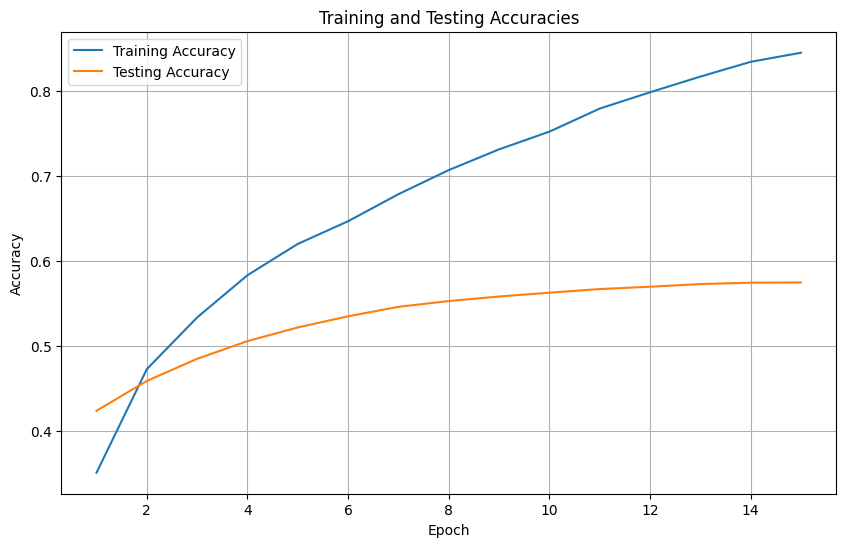

In [81]:
# create training and test loop
epochs = 15
train_accuracy = Accuracy(task='MULTICLASS', num_classes=6).to(device)
test_accuracy = Accuracy(task='MULTICLASS', num_classes=6).to(device)

train_accuracies = []
test_accuracies = []

def train_loop(model, dataloader, loss_fn, optimizer, accuracy_fn):
    train_loss = 0 # initialise train loss to 0
    for batch, (X_train ,y_train) in enumerate(dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        model.train() # set to training mode
        y_pred = model(X_train) # make predictions on training set features

        loss = loss_fn(y_pred, y_train) # compare predictions to actual training labels
        train_loss += loss # add loss to train loss

        optimizer.zero_grad() # reset gradients
        loss.backward() # backpropagation
        optimizer.step() # calculate gradients

        accuracy_fn.update(y_pred.argmax(dim=1), y_train) # update accuracy, compare prediciton with actual label

        if batch % 50 == 0:
            print(f"Looked at {batch*len(X_train)}/{len(dataloader.dataset)} samples")

    avg_train_loss = train_loss/len(dataloader) # average training loss
    train_acc = accuracy_fn.compute() # training accuracy
    print(f"Average Training Loss: {avg_train_loss}, Training Accuracy: {train_acc.item()}")
    accuracy_fn.reset()
    return train_acc.item()

def test_loop(model, dataloader, loss_fn, optimizer, accuracy_fn):
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for X_test, y_test in dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_pred = model(X_test)
            test_loss += loss_fn(test_pred, y_test)
            accuracy_fn.update(test_pred.argmax(dim=1), y_test) # argmax(dim=1 so we can compare labels to labels, not logits
        avg_test_loss = test_loss/len(dataloader)
        test_acc = accuracy_fn.compute()
    print(f"Average Testing Loss: {avg_test_loss}, Testing Accuracy: {test_acc.item()}")
    return test_acc.item()

for epoch in range(epochs):
    print(f"Epoch: {epoch}----------")

    # training loop
    train_acc = train_loop(model, train_loader, loss_fn, optimizer, train_accuracy)
    train_accuracies.append(train_acc)

    # test loop
    test_acc = test_loop(model, val_loader, loss_fn, optimizer, test_accuracy)
    test_accuracies.append(test_acc)

# Plotting accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies')
plt.legend()
plt.grid(True)
plt.show()



In [93]:
def make_predictions(model, data):
    pred_probs = [] # initialise empty predction probabilities
    model.eval() # eval mode when making predictions
    with torch.no_grad():
        for sample in data:

            # prepare sample (add batch dimension)
            sample = torch.unsqueeze(sample.to(device), dim=0)

            # forward pass (model outputs logits)
            pred_logit = model(sample)
            pred_probability = torch.softmax(pred_logit.squeeze(), dim=0) # softmax for multiclass classification
            pred_probs.append(pred_probability)
    return torch.stack(pred_probs) # concatenate all probabilities into single tensor

import random
random.seed(20)
test_samples = []
test_labels = []

for sample, label in random.sample(list(val_dataset), k=25): # take 9 random samples from the test data
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 48, 48])

In [94]:
# make predictions on samples
pred_probs = make_predictions(model=model,
                              data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 3, 0, 3, 5, 5, 3, 4, 0, 2, 4, 3, 0, 0, 0, 4, 0, 2, 5, 3, 2, 0, 3, 5,
        5], device='cuda:0')

(-0.5, 47.5, 47.5, -0.5)

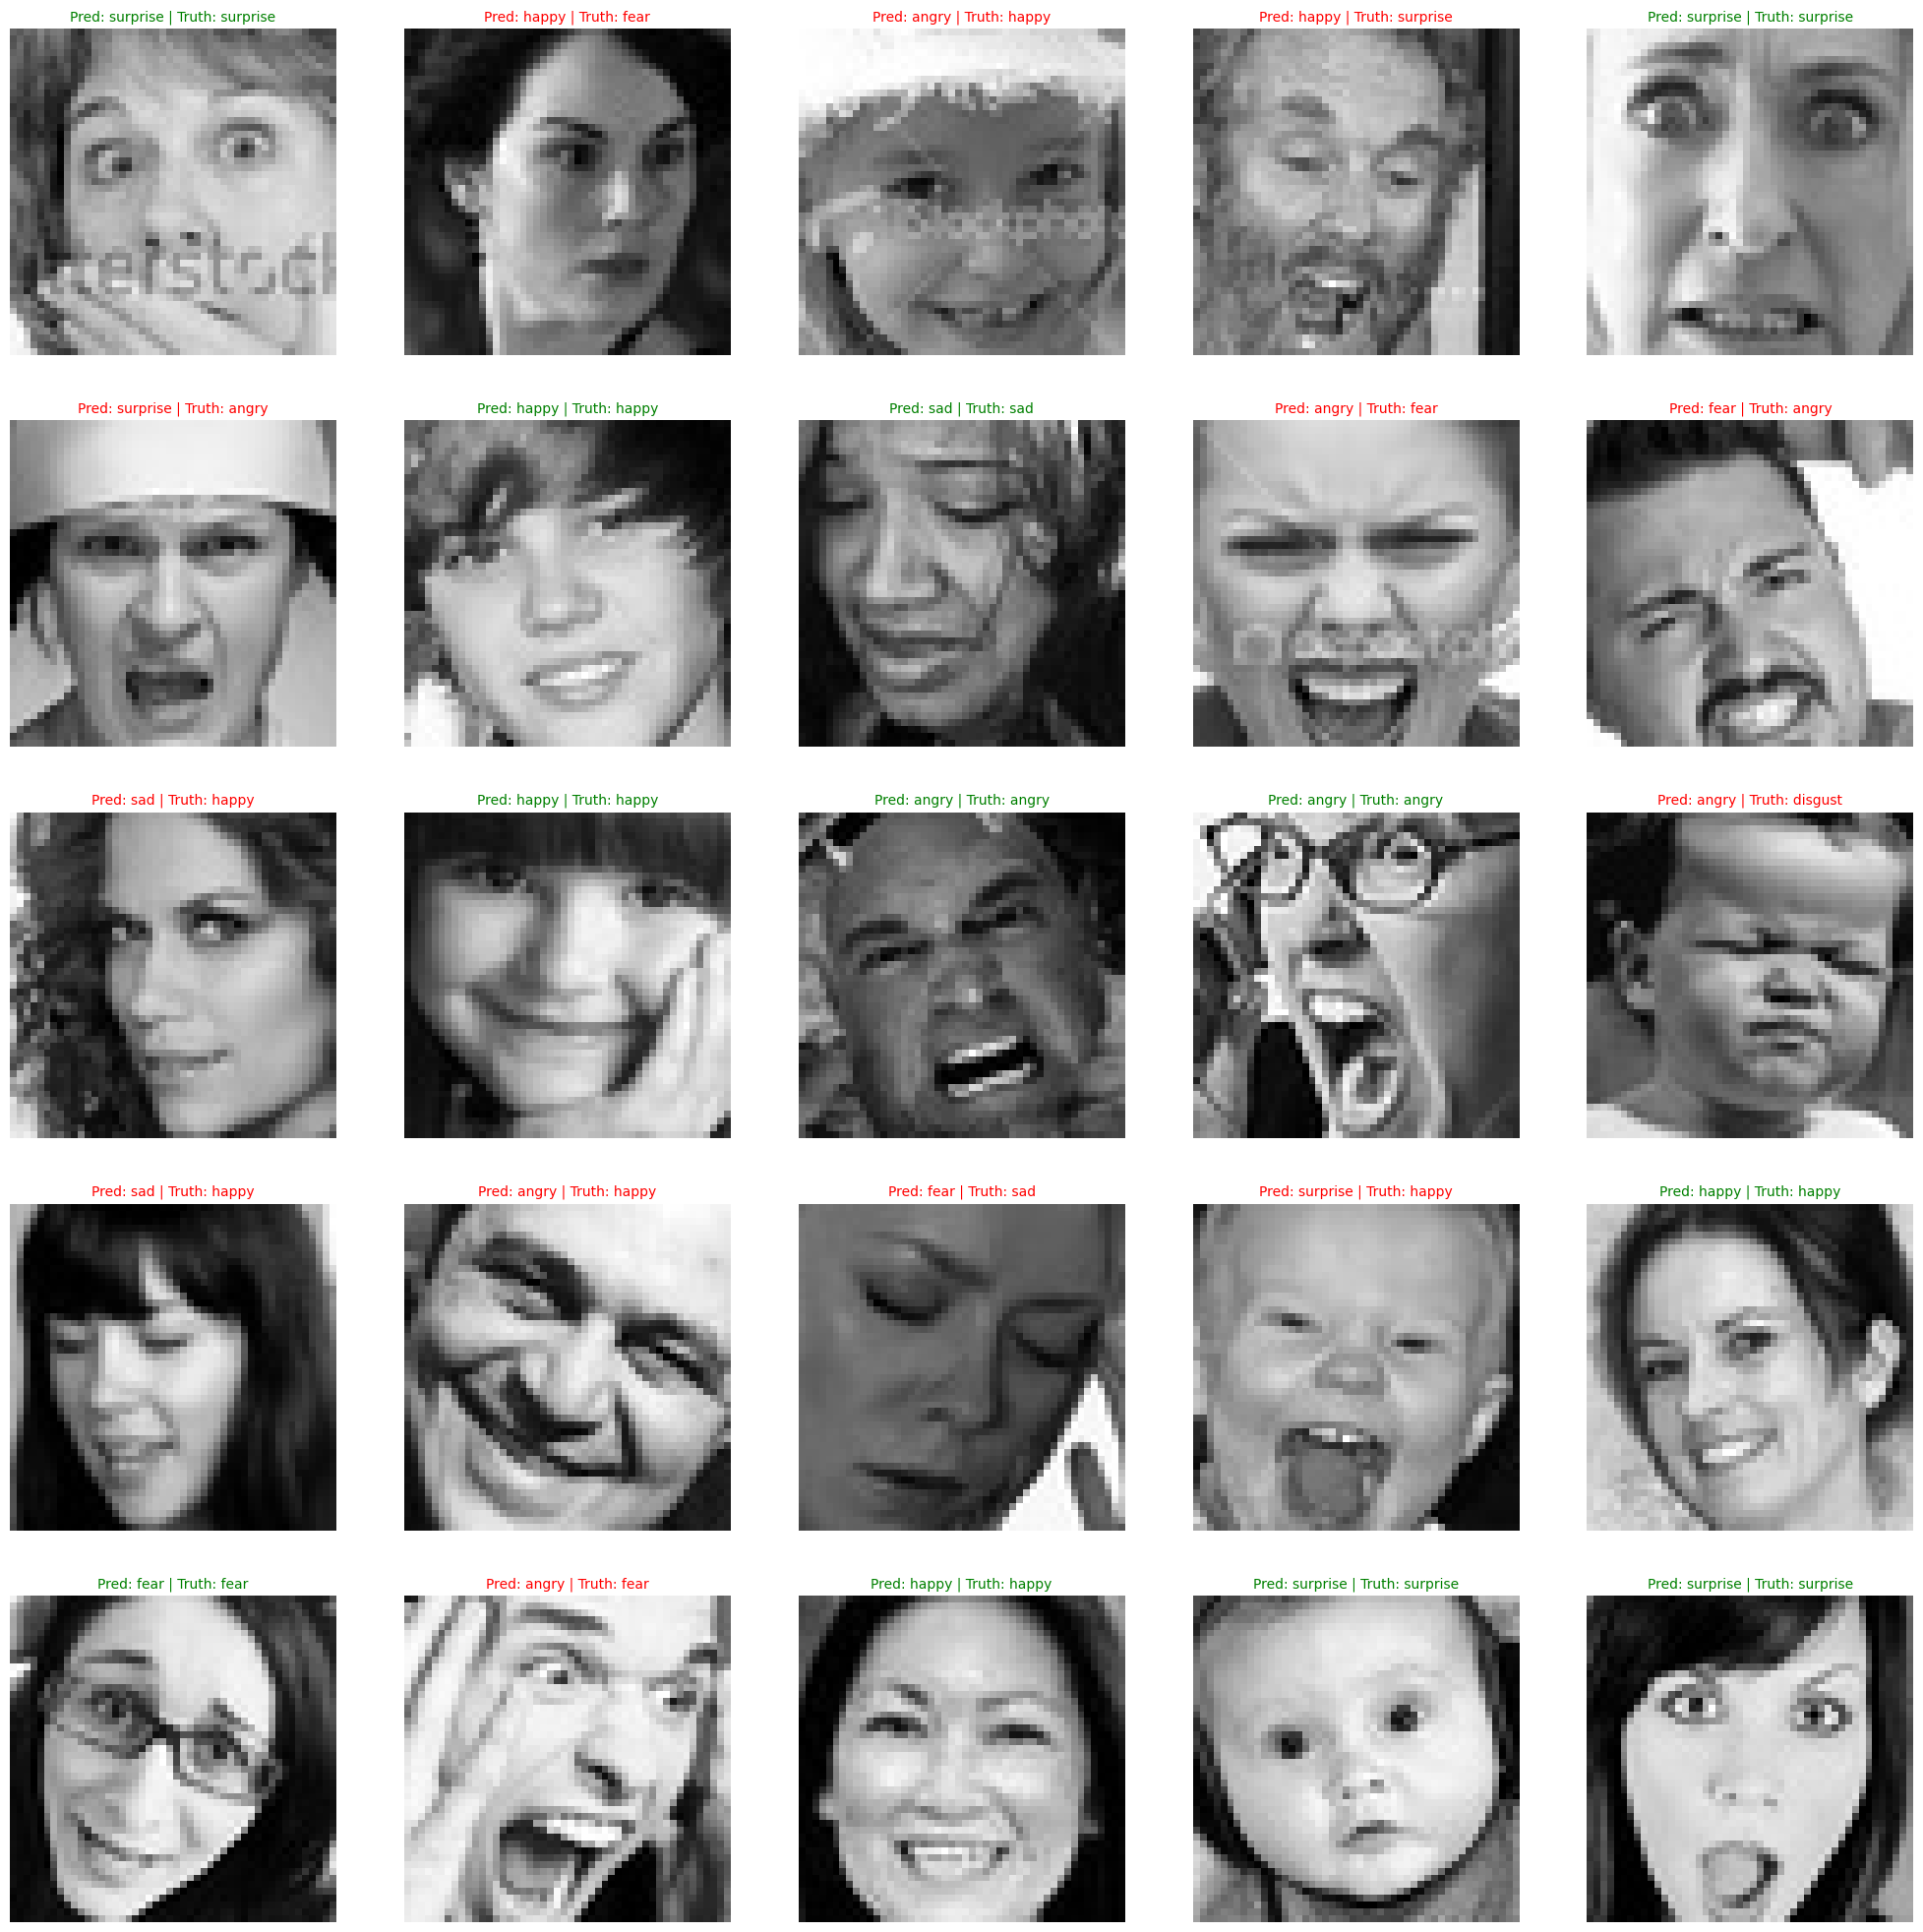

In [95]:
plt.figure(figsize=(25,25)) # set figure first
nrows = 5
ncols = 5 # set rows and cols of an image
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray") # remove batch dimension
    pred_label = class_names[pred_classes[i]] # predicted label of image
    truth_label = class_names[test_labels[i]] # actual label of the image
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis(False)
plt.axis(False)

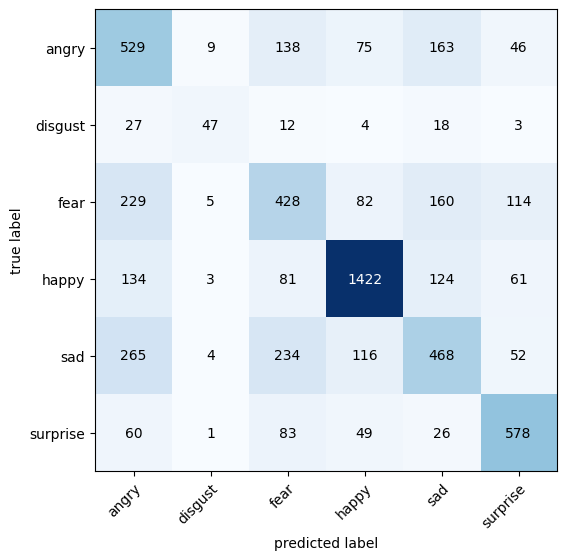

In [66]:
# create a confusion matrix
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.no_grad():
  for X, y in val_loader:
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred)
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

# 2. setup confusion matrix and compare predictions to targets
confmat = ConfusionMatrix(num_classes=6, task="multiclass").to(device)
confmat_tensor = confmat(preds=y_pred_tensor.to(device),
                         target=torch.tensor(val_dataset.targets).to(device))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 6)
);

In [96]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'mood_v2.pth')

In [5]:
new_model = MoodRecognitionModel(input_shape=1, hidden_units=128, dropout_rate=0.1)

# Load the checkpoint
checkpoint = torch.load('mood_v2.pth', map_location=torch.device('cpu'))

# Load the state dict into the model
new_model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
new_model.eval()


MoodRecognitionModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18432, out_features=6, bias=True)
  )
)

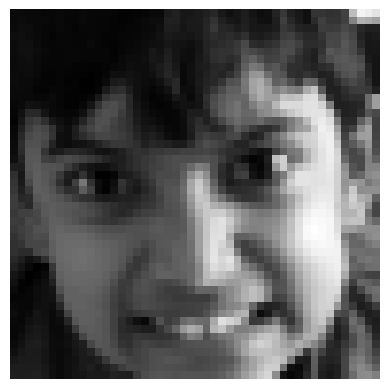

Predicted class: angry
Probabilities:
angry: 0.4150
disgust: 0.0054
fear: 0.3318
happy: 0.1455
sad: 0.0700
surprise: 0.0322


In [6]:
from PIL import Image
from facenet_pytorch import MTCNN

class_names = ['angry', 'disgust', 'fear', 'happy','sad','surprise']


def preprocess_image(image):
  image = Image.open(image_path).convert('L')
  transform=transforms.Compose([
      transforms.Resize((48,48)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor(),
  ])
  image = transform(image).unsqueeze(0)
  return image

image_path = 'test_6.jpg'
input_tensor = preprocess_image(image_path).to(device)

new_model.eval()

# Perform inference
with torch.no_grad():
    output = new_model(input_tensor)

# Assuming output is logits, you might want to apply softmax to get probabilities
probabilities = torch.softmax(output, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

# Convert tensor back to PIL image for visualization
pil_image = transforms.ToPILImage()(input_tensor.squeeze())

# Plot the image using matplotlib
plt.imshow(pil_image, cmap='gray')  # Display the image in grayscale
plt.axis('off')  # Turn off axis labels
plt.show()
# Print predicted class or use it as needed
print(f"Predicted class: {class_names[predicted_class]}")
print("Probabilities:")
for i, prob in enumerate(probabilities.squeeze().tolist()):
    print(f"{class_names[i]}: {prob:.4f}")

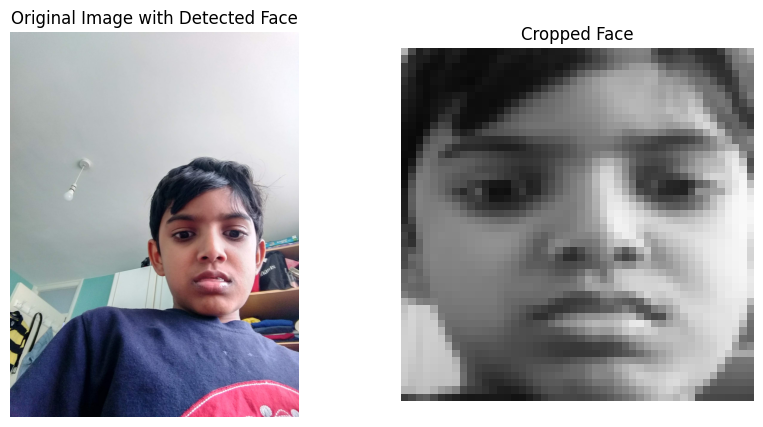

Predicted class: sad
Probabilities:
angry: 0.3956
disgust: 0.1158
fear: 0.0250
happy: 0.0002
sad: 0.4440
surprise: 0.0194


In [16]:
# !pip install facenet_pytorch

import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN

# Define your class names for mood recognition
class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']

# Device configuration (assuming you have a GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model (assuming `new_model` is already defined and loaded)
new_model = MoodRecognitionModel(input_shape=1, hidden_units=128, dropout_rate=0.1)
checkpoint = torch.load('mood_v2.pth', map_location=torch.device('cpu'))
new_model.load_state_dict(checkpoint['model_state_dict'])
new_model.eval()
new_model.to(device)

# Function to preprocess image and detect/crop face
def preprocess_image(image_path):
    # Load image
    image = Image.open(image_path).convert('RGB')

    # Initialize MTCNN for face detection
    mtcnn = MTCNN(keep_all=True, device=device)

    # Detect faces
    boxes, probs = mtcnn.detect(image)

    # Ensure a face was detected
    if boxes is not None:
        # Select the first face (you may modify this logic based on your requirements)
        box = boxes[0]

        # Convert box coordinates to integers
        box = [int(b) for b in box]

        # Crop face from image
        face = image.crop((box[0], box[1], box[2], box[3]))

        # Preprocess cropped face for model input
        transform = transforms.Compose([
            transforms.Resize((48, 48)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])
        face_tensor = transform(face).unsqueeze(0).to(device)

        return face, face_tensor

    else:
        print("No face detected in the image.")
        return None, None

# Example usage
image_path = 'uncropped_6.jpg'
face, input_tensor = preprocess_image(image_path)
image = Image.open(image_path).convert('RGB')

if face is not None and input_tensor is not None:
    # Perform inference on the cropped face
    with torch.no_grad():
        output = new_model(input_tensor)

    # Assuming output is logits, apply softmax to get probabilities
    probabilities = F.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    # Convert face PIL image back to numpy array for visualization
    face_np = transforms.ToPILImage()(input_tensor.squeeze().cpu()).convert('RGB')

    # Display the original image with the detected face
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image with Detected Face')
    plt.axis('off')

    # Display the cropped face
    plt.subplot(1, 2, 2)
    plt.imshow(face_np, cmap='gray')
    plt.title('Cropped Face')
    plt.axis('off')

    plt.show()

    # Print predicted class and probabilities
    print(f"Predicted class: {class_names[predicted_class]}")
    print("Probabilities:")
    for i, prob in enumerate(probabilities.squeeze().tolist()):
        print(f"{class_names[i]}: {prob:.4f}")
